In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy
import os

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [2]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df


In [3]:
def predict_grid(model, x1_key, x2_key, device, mcdropout:bool = False, nx:int = 100, n_MC:int = 100):
    x1_lim = 25
    x2_lim = 25
    x1 = np.linspace(-x1_lim, x1_lim, nx)
    x2 = np.linspace(-x2_lim, x2_lim, nx)
    xx1, xx2 = np.meshgrid(x1, x2)
    df = pd.DataFrame(columns = ["x1", "x2"], index = range(len(xx1.flatten())))
    df["x1"] = xx1.flatten()
    df["x2"] = xx2.flatten()
    df = cartesian_to_polar_df(df, "x1", "x2", "r_x", "a_x")

    X_gridtest = torch.Tensor(np.dstack((df[x1_key], df[x2_key]))).to(torch.float32)[0]
    Y_gridtest = torch.zeros(X_gridtest.shape)
    gridtest_dataset = torch.utils.data.TensorDataset(X_gridtest, Y_gridtest)
    if mcdropout:
        mean_val, variance_val = mc_predictions(model, gridtest_dataset, 2**8, n_MC, 2, len(df), )
        #Get average softmax score for blue
        df["Confidence_MC"] = mean_val[:,-1]
        df["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
        # Error is the same for both scores
        df["Std_MC"] = np.sqrt(variance_val[:,1])
    else:
        truth, logits = predict_classifier(model, gridtest_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        df["Prediction"] = preds
        #Get softmax score for red
        df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
    return df

In [4]:
def predict_MCD(model, df, test_dataset, device, n_MC:int = 100):
     # Predict with just model
    truth, logits = predict_classifier(model, test_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df["Prediction"] = preds
    df["Truth"] = truth

    #Get softmax score for blue
    df["Confidence"] = torch.softmax(logits, dim=-1)[:,1]

    # Predict with MC dropout
    mean_val, variance_val = mc_predictions(model, test_dataset, 2**8, n_MC, 2, len(test_dataset))
    df["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
    df["Confidence_MC"] = mean_val[:,-1]
    # Error is the same for both scores
    df["Std_MC"] = np.sqrt(variance_val[:,0])
    return df

In [5]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [6]:
# Experiment
def mc_dropout_experiment(X_train, Y_train, test_dataset, valfile, x1_key, x2_key, patience, n_train, p_MC, n_MC):
    
    n_df = max([len(n_train), len(p_MC), len(n_MC)])
    if (len(np.array(n_train)) < n_df):
        n_train = [n_train]*n_df
    if (len(np.array(p_MC)) < n_df):
        p_MC = [p_MC]*n_df
    if (len(np.array(n_MC)) < n_df):
        n_MC = [n_MC]*n_df

    test_data_dfs = [pd.read_csv(f"../data/{valfile}.csv") for i in range(len(n_df))]
    grid_dfs = [pd.DataFrame(columns = ["x1", "x2", "r_x", "a_x"], index = range(100*100)) for i in range(len(n_df))]
    
    for i in range(n_df):
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train[i]], Y_train[0:n_train[i]])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=p_MC[i]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                test_dataset, batchsize=2**8, epochs = 80, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict with just model
        truth, logits = predict_classifier(model, test_dataset, 2, 100, device)
        preds = torch.argmax(logits, dim=-1).flatten()
        test_data_dfs[i]["Prediction"] = preds
        test_data_dfs[i]["Truth"] = truth

        #Get softmax score for blue
        test_data_dfs[i]["Confidence"] = torch.softmax(logits, dim=-1)[:,1]
        
        #Predict grid without MC dropout
        grid_dfs[i] = predict_grid(model, x1_key, x2_key, device)

        # Predict with MC dropout
        mean_val, variance_val = mc_predictions(model, test_dataset, 2**8, n_MC[i], 2, len(test_dataset))
        test_data_dfs[i]["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
        test_data_dfs[i]["Confidence_MC"] = mean_val[:,-1]
        # Error is the same for both scores
        test_data_dfs[i]["Std_MC"] = np.sqrt(variance_val[:,0])

        # Predict grid with MC dropout
        grid_MC = predict_grid(model, x1_key, x2_key, device, mcdropout=True)
        grid_dfs[i]["Prediction_MC"] = grid_MC["Prediction_MC"]
        grid_dfs[i]["Confidence_MC"] = grid_MC["Confidence_MC"]
        grid_dfs[i]["Std_MC"] = grid_MC["Std_MC"]
    return test_data_dfs, grid_dfs

In [7]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
#n_data = [10, 50]
patience = 150
load_values = True

#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
gridfile = f"x1_x2_grid"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
truth_data = pd.read_csv(f"../analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"../analytical/results/{truthfile_test}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")


#Correct analytical solution if class distribution is not equal
if p_red != 0.5:
    truth_data["P_red_and_x"] = truth_data["P_red_and_x"]*(p_red)/0.5
    truth_data["P_blue_and_x"] = truth_data["P_blue_and_x"]*(1-p_red)/0.5
    truth_data["P_x"] = truth_data["P_red_and_x"] + truth_data["P_blue_and_x"]
    truth_data["P_red_given_x"] = truth_data["P_red_and_x"]/truth_data["P_x"]
    truth_data["P_blue_given_x"] = truth_data["P_blue_and_x"]/truth_data["P_x"]

# Prepare data for pytorch
train_data = word_to_int(train_data)
val_data = word_to_int(val_data)
test_data = word_to_int(test_data)

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = torch.zeros(X_test.shape)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [8]:
# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

### Increasing number of datapoints

In [9]:
drop_out_rate = 0.3
n_MC=200
n_data = [250, 500, 1000, 5000, 10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25

test_dfs = [0]*len(n_data)
grid_dfs = [0]*len(n_data)

if load_values==False:
    for i in range(len(n_data)):
        grid_dfs[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs[i] = pd.read_csv(f"../data/{testfile}.csv")
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data[i]], Y_train[0:n_data[i]])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=drop_out_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                test_dataset, batchsize=2**10, epochs = 250, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict
        test_dfs[i] = predict_MCD(model, test_dfs[i], test_dataset, device, n_MC=n_MC)
        grid_dfs[i] = predict_MCD(model, grid_dfs[i], grid_dataset, device, n_MC=n_MC)

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
        grid_dfs[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
else:
    for i in range(len(n_data)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")
        grid_dfs[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_nMC_{n_MC}_Vndata-{n_data[i]}.csv")


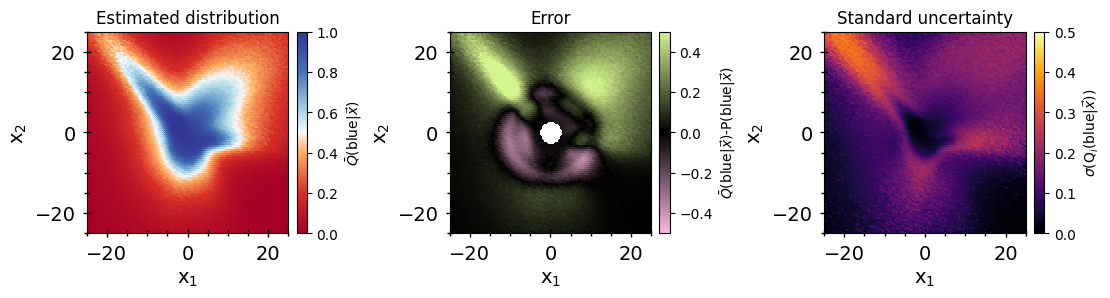

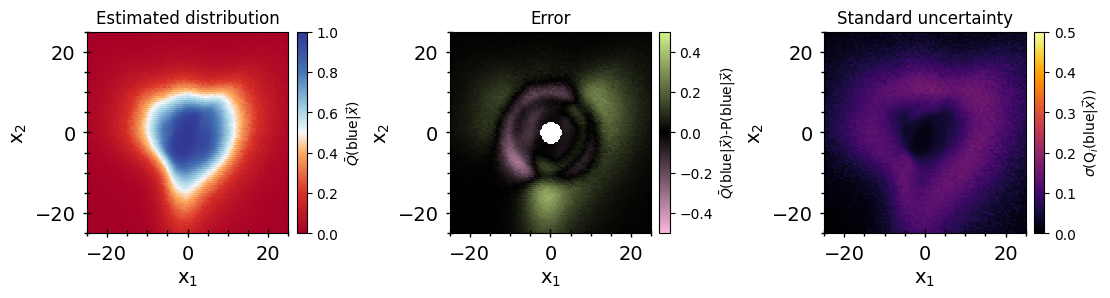

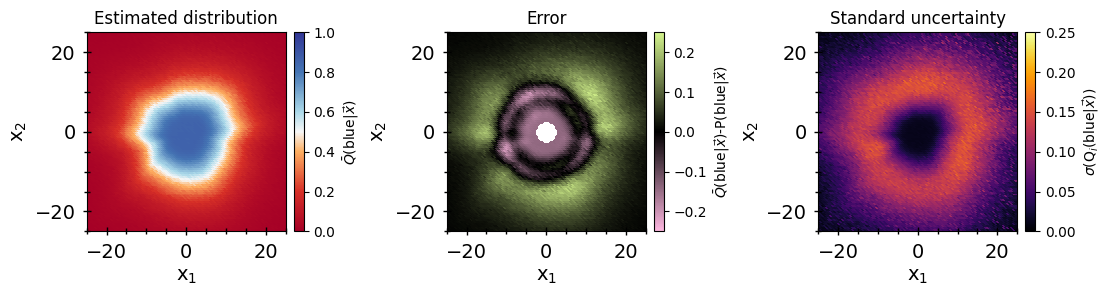

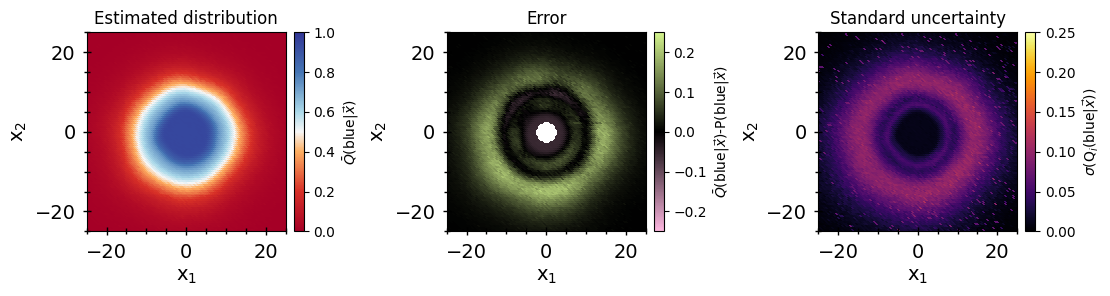

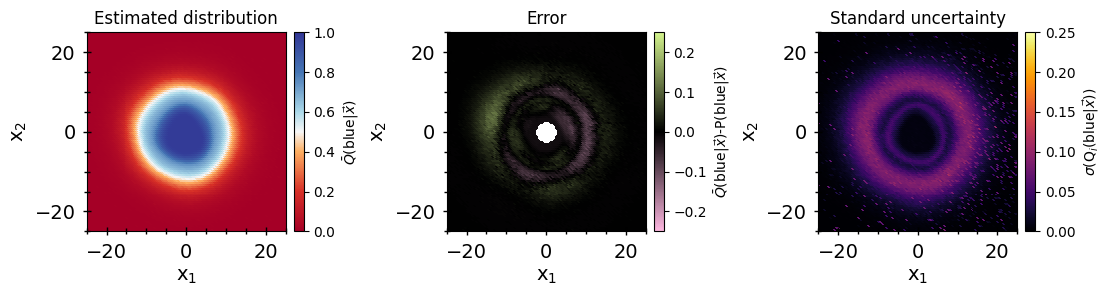

In [10]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_dfs[i], "Confidence_MC", axs[0], "Estimated distribution", grid=True)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_dfs[i], truth_data, "Confidence_MC", "P_blue_given_x", axs[1], r"Error", max_val = max_err_val[i])
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_dfs[i], "Std_MC", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i])
    
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                 label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.savefig(f"../fig/MCD_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}. Drop out rate: {drop_out_rate}", fontsize=14)

In [11]:
scores = calculate_metrics(test_dfs, grid_dfs, n_data, truth_data, truth_test_data, 
                           "Prediction_MC", "Confidence_MC", "Std_MC")

print(scores)

   N data     ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.6520  0.731819  0.049862  0.116471  0.134113  0.044917   
1     500  0.7134  0.793592  0.047425  0.051346  0.106409  0.029809   
2    1000  0.7283  0.813606  0.072915  0.065760  0.106973  0.035790   
3    5000  0.7421  0.820719  0.056037  0.053276  0.062873  0.025462   
4   10000  0.7425  0.821227  0.020081  0.014675  0.055933  0.023558   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.054244          0.096791  0.605313  0.061104  0.131238  0.071417  
1          0.029829          0.028876  0.546447  0.024326  0.049146  0.029204  
2          0.023581          0.030712  0.539611  0.072866  0.127578  0.079086  
3          0.021061          0.016675  0.525521  0.054503  0.132528  0.070146  
4          0.013679          0.001684  0.511023  0.024720  0.066093  0.029776  


### Results for MC dropout during training only

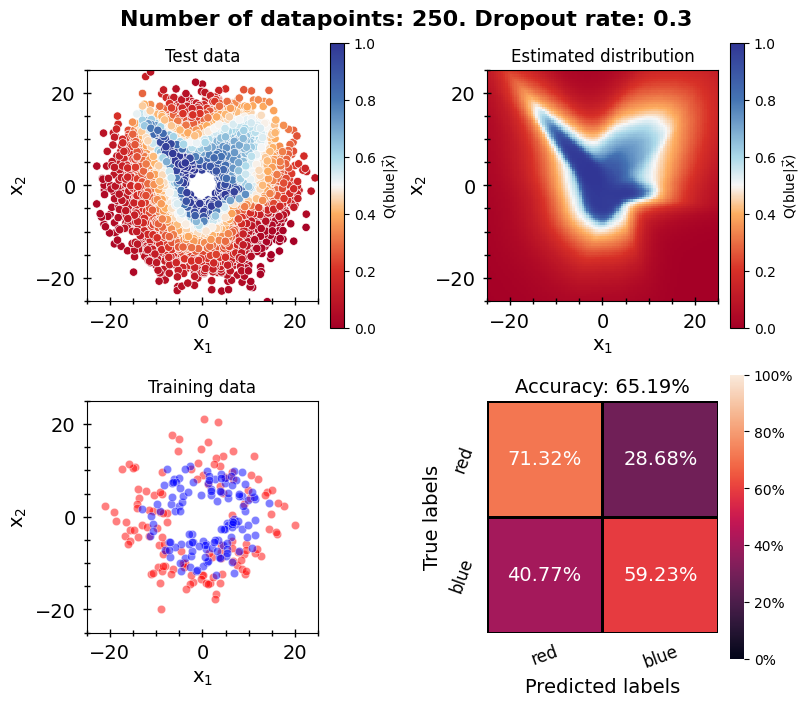

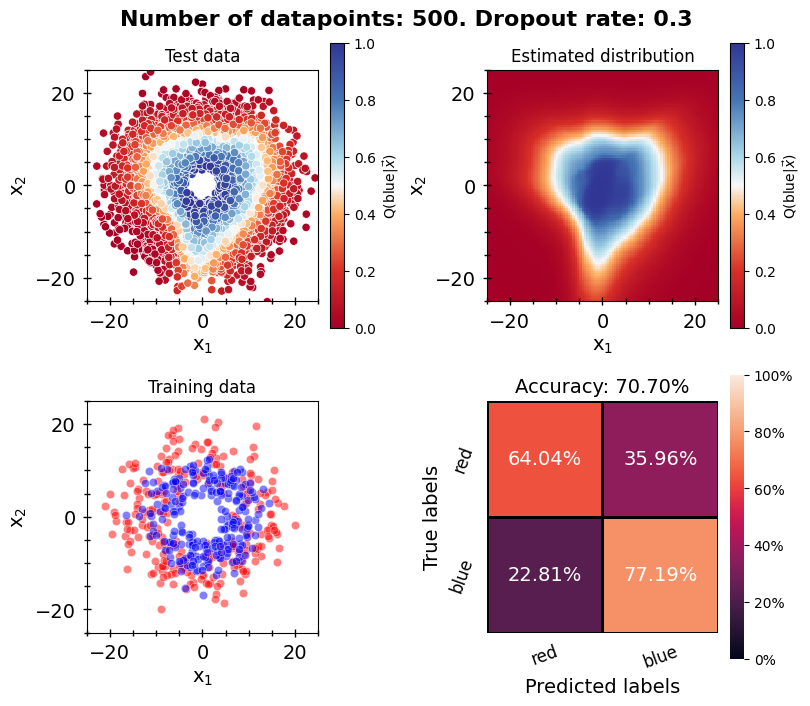

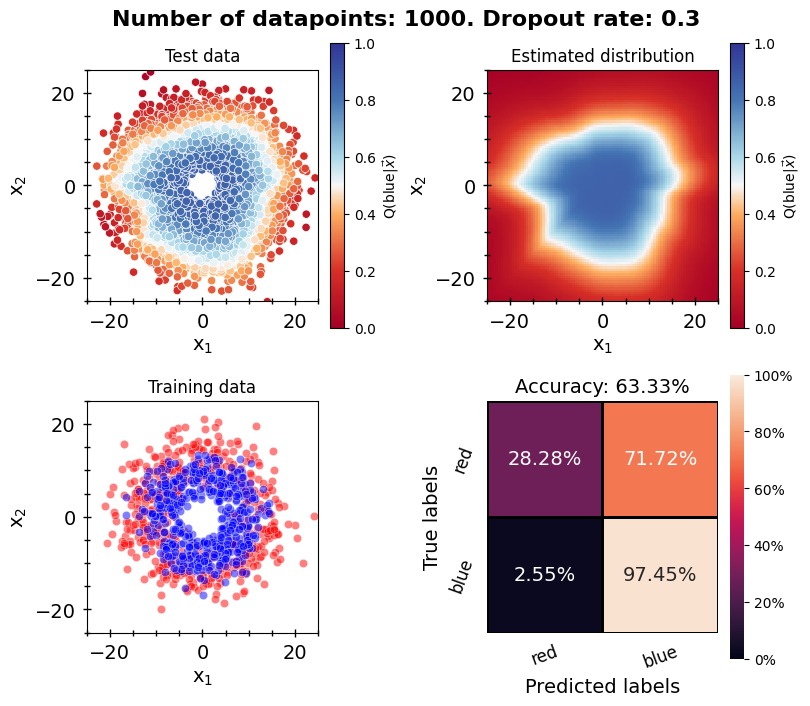

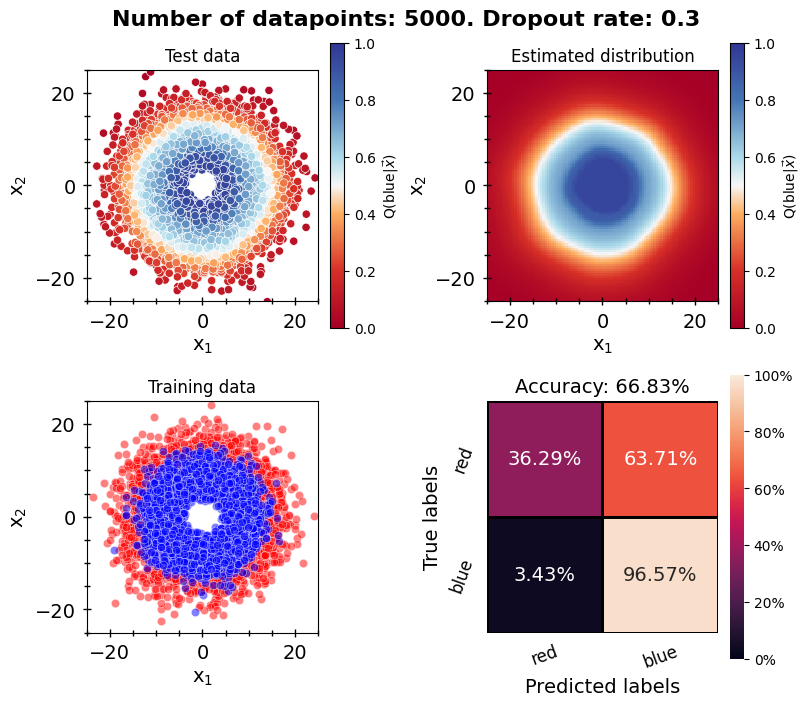

In [19]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Confidence", axs[0][0], "Test data")
    axs[0][1] = plot_grid(grid_dfs[i], "Confidence", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")

### Plot MC dropout during training and inference results

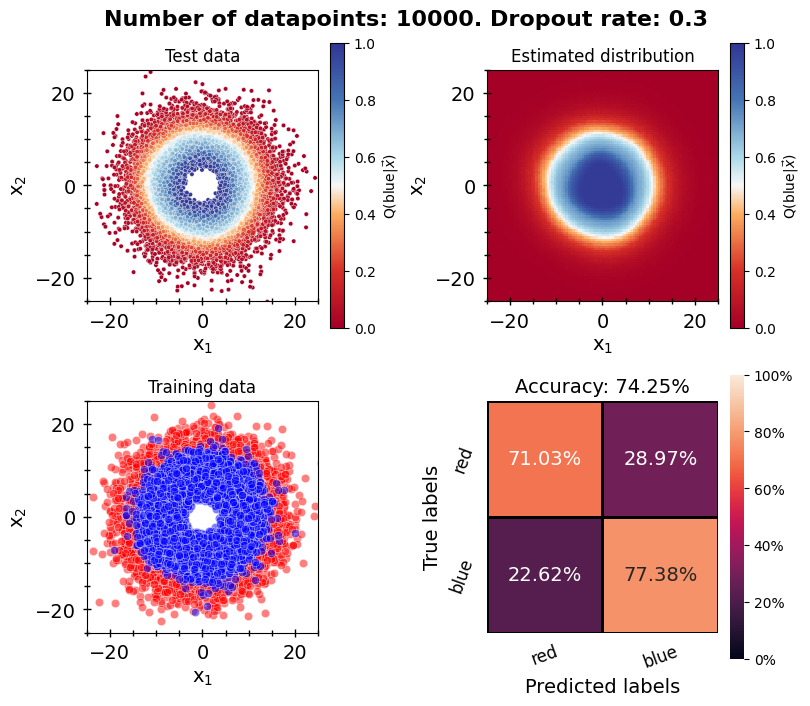

In [30]:
# Plot
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs[i], "Confidence_MC", axs[0][0], "Test data", error_key="Std_MC")
    axs[0][1] = plot_grid(grid_dfs[i], "Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs[i], "class", "Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")


In [21]:
test_data

color         x1         x2        a1        a2         r1  r2  \
0      red   4.637181  11.350187  0.935784  1.553757  11.837233   3   
1      red  10.042744  10.382106  0.682262  0.612850  11.887063   3   
2     blue  -5.605532  11.920284  1.943990  0.295500  10.273541   3   
3     blue  -1.477669 -14.679668  4.577589  0.170343  11.788505   3   
4     blue  -9.945727   8.379890  2.213879  1.781017  13.296149   3   
...    ...        ...        ...       ...       ...        ...  ..   
9995   red   0.596807   9.253463  1.318706  2.526894  11.560692   3   
9996  blue  -6.404741   6.863661  1.997287  1.496279   8.674995   3   
9997  blue -11.277142   2.093363  2.757517  0.865739   9.295702   3   
9998   red   8.927445  11.836816  0.898653  3.012991  17.796208   3   
9999  blue  -3.594322  -8.356490  4.193690  2.794252  11.860049   3   

            r_x       a_x  class  
0     12.260921  1.182936      0  
1     14.444543  0.802012      0  
2     13.172515  2.010363      1  
3     14.753853  4.612066      1  
4     13.005386  2.441433      1  
...         ...       ...    ...  
9995   9.272689  1.506390      0  
9996   9.387787  2.321621      1  
9997  11.469791  2.958053      1  
9998  14.825974  0.924606      0  
9999   9.096707  4.306187      1  

[10000 rows x 10 columns]

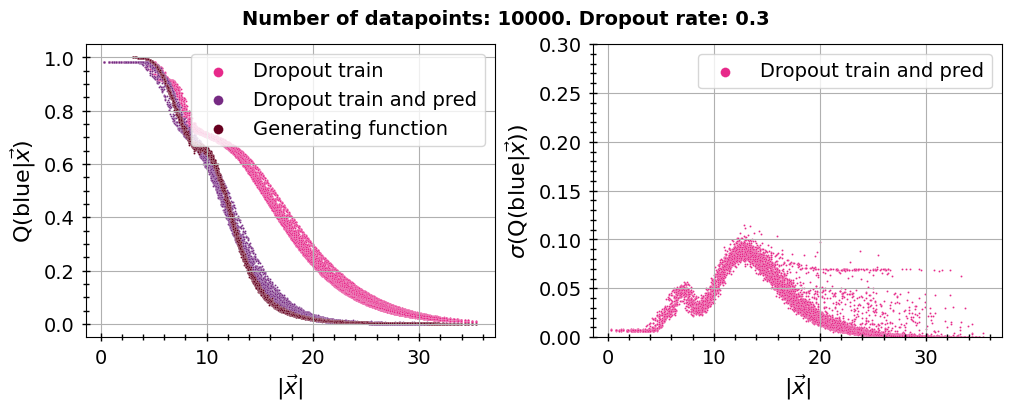

In [31]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence", s=2, ax = axs[0], label="Dropout train", color="#e7298a")
    sn.scatterplot(grid_dfs[i], x="r_x", y="Confidence_MC", s=2, ax = axs[0], label="Dropout train and pred", color="#762a83")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs[i], x="r_x", y="Std_MC", s=2, ax = axs[1], label="Dropout train and pred", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}. Dropout rate: {drop_out_rate}", size=14, fontweight="bold")

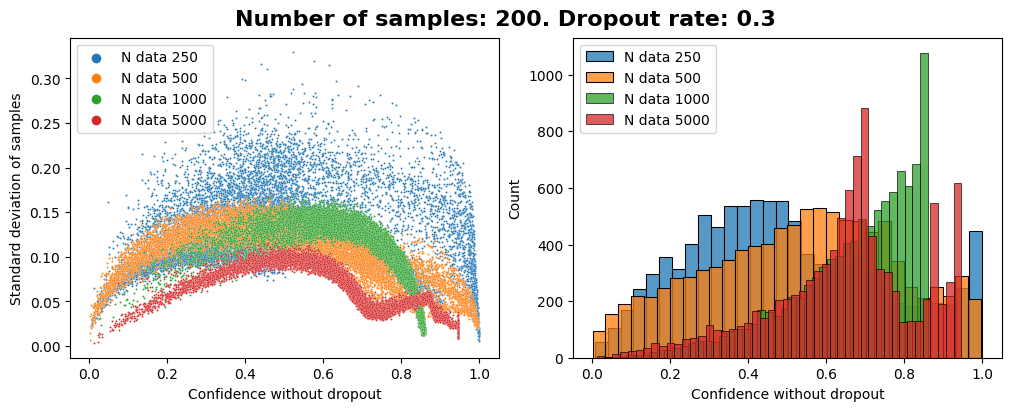

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Confidence", y=f"Std_MC", s=2, label=f"N data {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")

    sn.histplot(test_dfs[i], x="Confidence", label=f"N data {n_data[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of samples: {200}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")

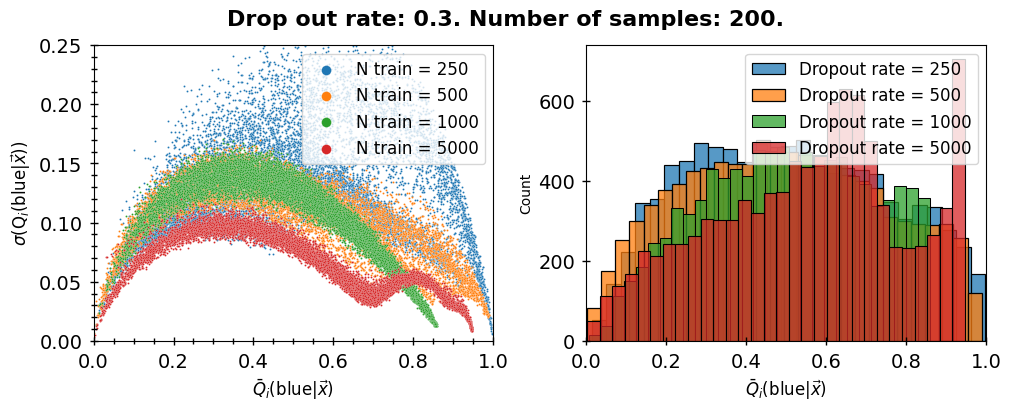

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_dfs[i], x="Confidence_MC", y="Std_MC", s=2, label=f"N train = {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs[i], x="Confidence_MC", label=f"Dropout rate = {n_data[i]}", ax = axs[1])
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[1].set_xlim(0, 1)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Drop out rate: {drop_out_rate}. Number of samples: {n_MC}.", size=16, fontweight="bold")

### Try different drop out rates

In [30]:

#p_drop_out = [0.1, 0.2, 0.3, 0.4, 0.5]
p_drop_out = [0.1, 0.2, 0.3, 0.4, 0.5]
n_train = 5000
n_MC=200
test_dfs_DO = [0]*len(p_drop_out)
grid_dfs_DO = [0]*len(p_drop_out)

if load_values==False:
    for i in range(len(p_drop_out)):
        grid_dfs_DO[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs_DO[i] = pd.read_csv(f"../data/{testfile}.csv")
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=p_drop_out[i]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**10, epochs = 250, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict
        test_dfs_DO[i] = predict_MCD(model, test_dfs_DO[i], test_dataset, device, n_MC=n_MC)
        grid_dfs_DO[i] = predict_MCD(model, grid_dfs_DO[i], grid_dataset, device, n_MC=n_MC)

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs_DO[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
        grid_dfs_DO[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
else:
    for i in range(len(p_drop_out)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs_DO[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")
        grid_dfs_DO[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_Vpd{p_drop_out[i]}_nMC_{n_MC}_ndata-{n_train}.csv")

    

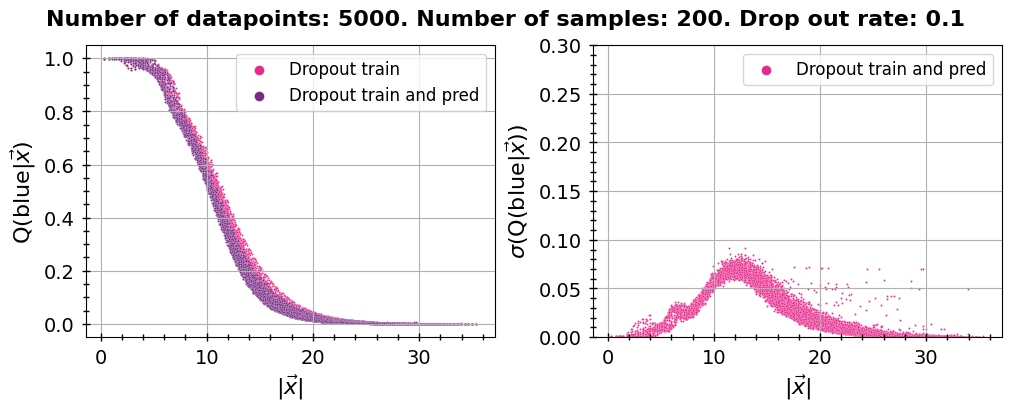

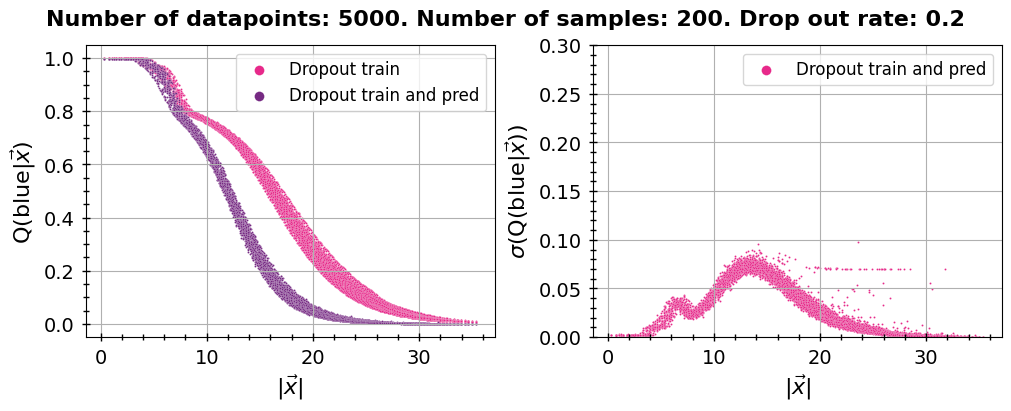

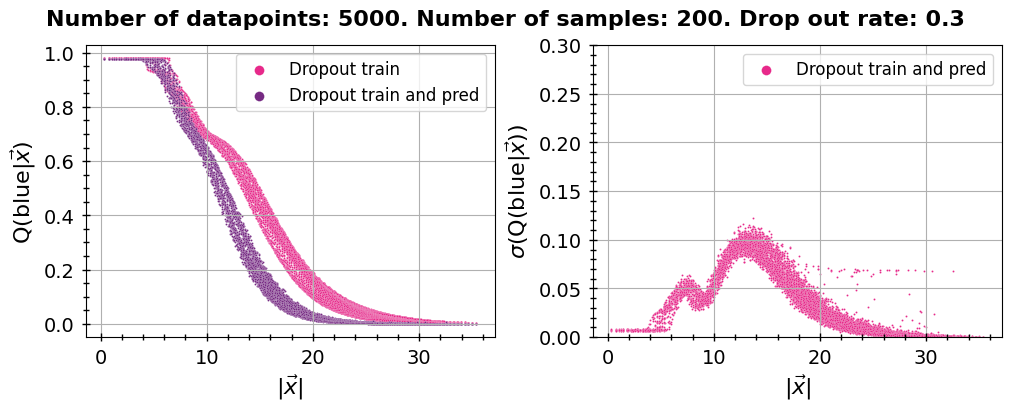

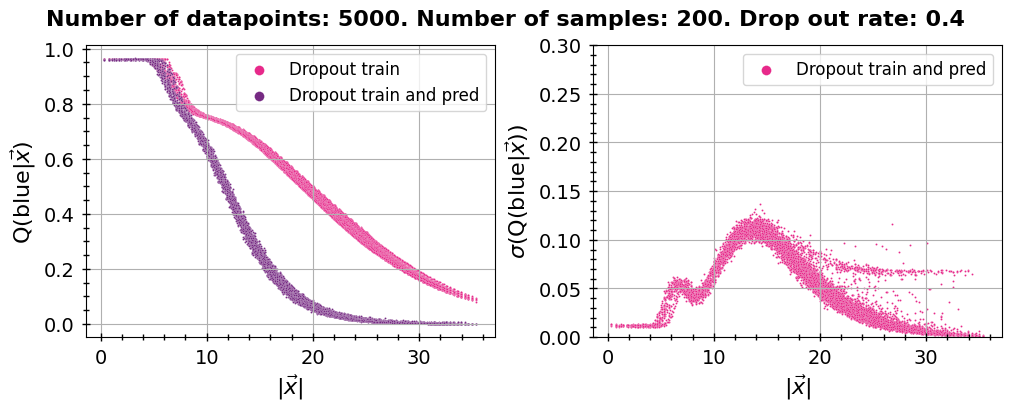

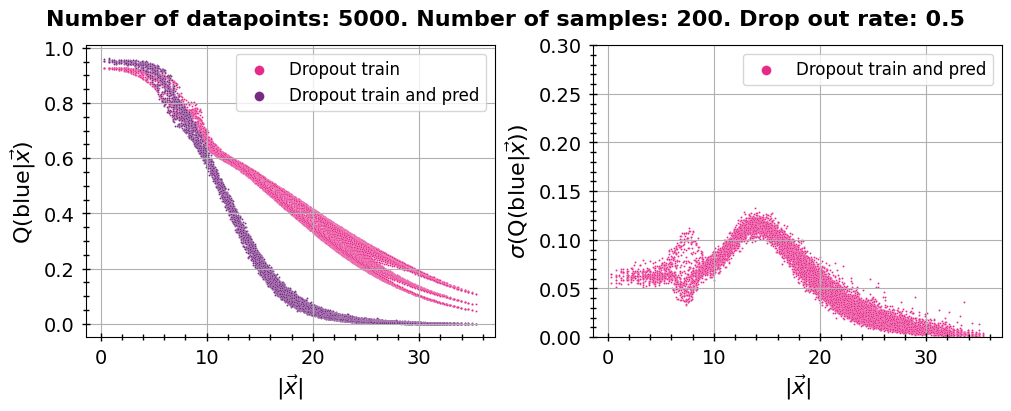

In [31]:
for i in range(len(p_drop_out)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Confidence", s=2, ax = axs[0], label="Dropout train", color="#e7298a")
    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Confidence_MC", s=2, ax = axs[0], label="Dropout train and pred", color="#762a83")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs_DO[i], x="r_x", y="Std_MC", s=2, ax = axs[1], label="Dropout train and pred", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=12)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}. Drop out rate: {p_drop_out[i]}", size=16, fontweight="bold")

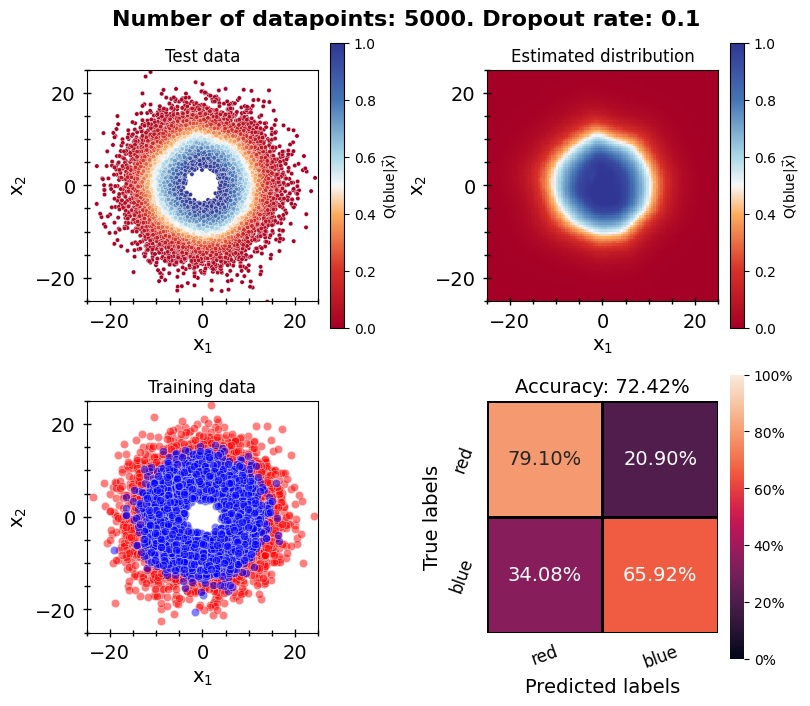

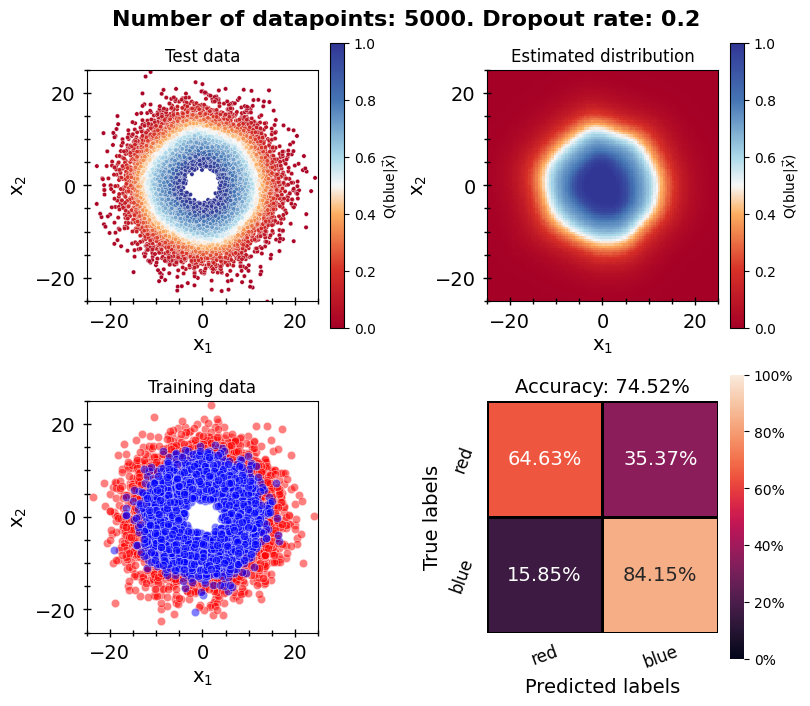

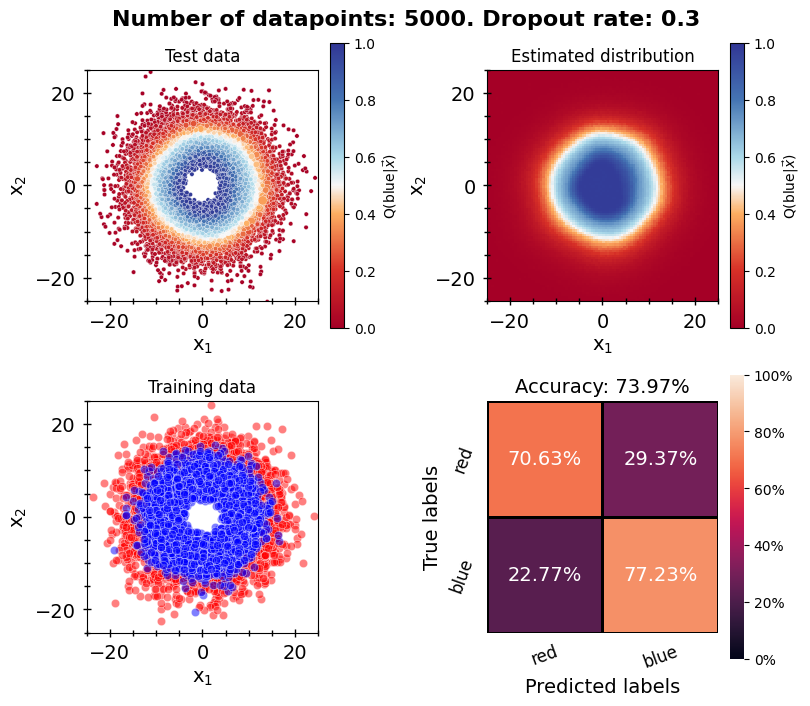

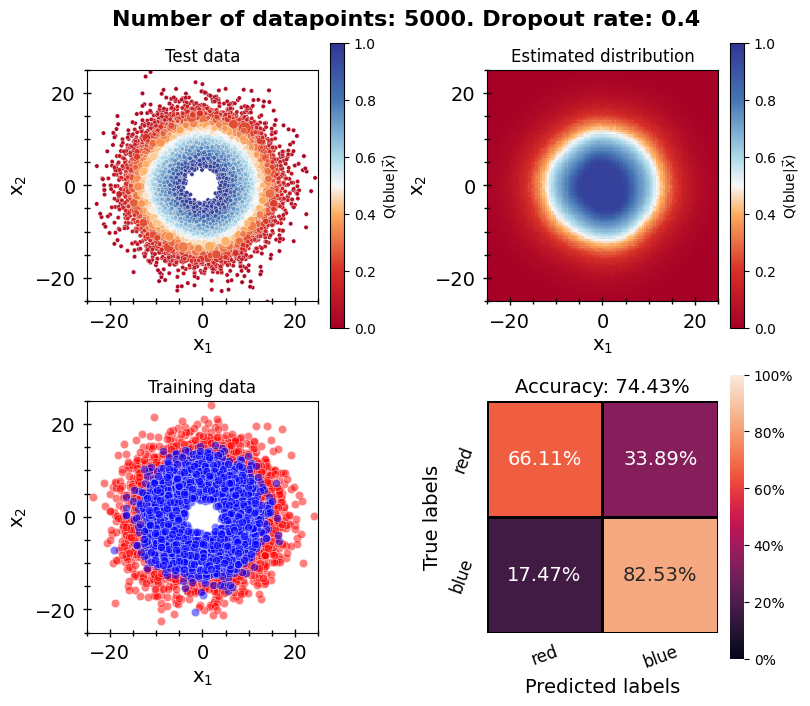

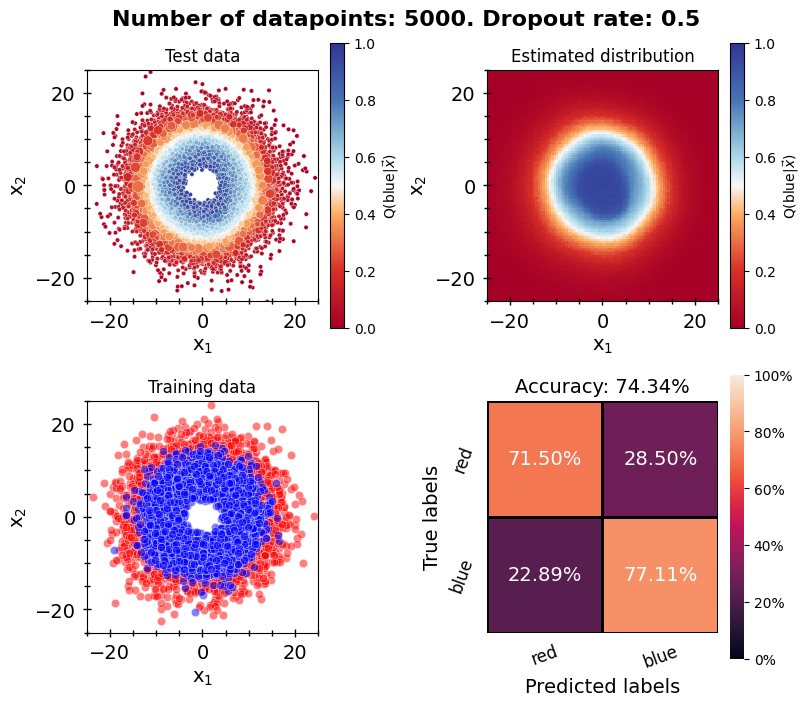

In [32]:
# Plot
for i in range(len(p_drop_out)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs_DO[i], "Confidence_MC", axs[0][0], "Test data", error_key="Std_MC")
    axs[0][1] = plot_grid(grid_dfs_DO[i], "Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs_DO[i], "class", "Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:5000], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_train}. Dropout rate: {p_drop_out[i]}", size=16, fontweight="bold")


### Standard deviation of MC dropout prediction

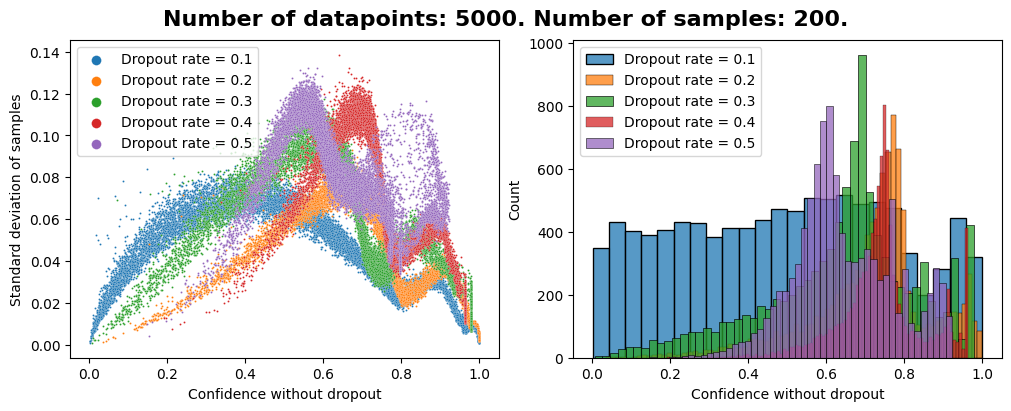

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(test_dfs_DO[i], x="Confidence", y="Std_MC", s=2, label=f"Dropout rate = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel("Standard deviation of samples")
    axs[0].set_xlabel("Confidence without dropout")
    sn.histplot(test_dfs_DO[i], x="Confidence", label=f"Dropout rate = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel("Confidence without dropout")
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}.", size=16, fontweight="bold")

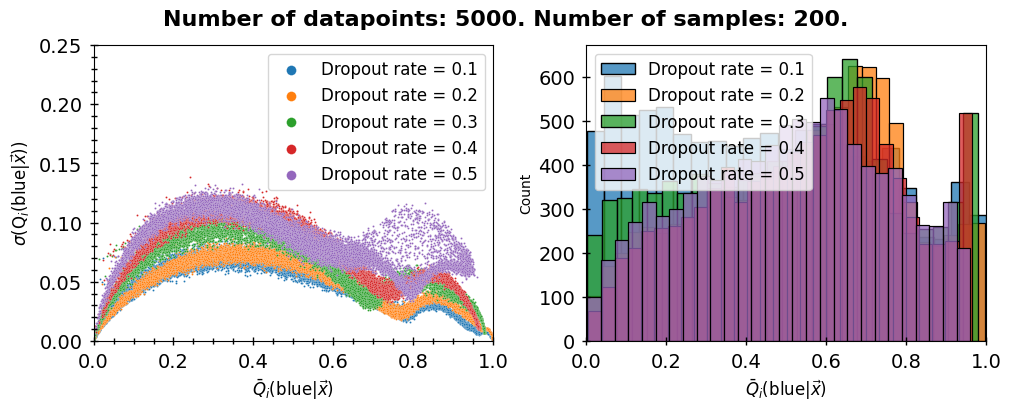

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(p_drop_out)):
    sn.scatterplot(test_dfs_DO[i], x="Confidence_MC", y="Std_MC", s=2, label=f"Dropout rate = {p_drop_out[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q$_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_dfs_DO[i], x="Confidence_MC", label=f"Dropout rate = {p_drop_out[i]}", ax = axs[1])
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"$\bar{Q}_i$(blue|$\vec{x}$)", fontsize=12)
    axs[1].set_xlim(0, 1)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. Number of samples: {n_MC}.", size=16, fontweight="bold")

In [39]:
n_MC_list = [10, 100, 1000]
n_train = 1000
drop_out_rate = 0.3
test_dfs_nMC = [0]*len(n_data)
grid_dfs_nMC = [0]*len(n_data)

if load_values==False:
    for i in range(len(p_drop_out)):
        grid_dfs_nMC[i] = pd.read_csv(f"../data/{gridfile}.csv")
        test_dfs_nMC[i] = pd.read_csv(f"../data/{testfile}.csv")
        # Create datasets for pytorch
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

        # Create model
        model = SequentialNet(L=1024*2, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=drop_out_rate).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**10, epochs = 250, 
                                device = device, optimizer = optimizer, early_stopping=patience)

        # Predict
        test_dfs_nMC[i] = predict_MCD(model, test_dfs_nMC[i], test_dataset, device, n_MC=n_MC_list[i])
        grid_dfs_nMC[i] = predict_MCD(model, grid_dfs_nMC[i], grid_dataset, device, n_MC=n_MC_list[i])

        # Save prediction
        if (not os.path.isdir(f"predictions/{trainfile}") ):
            os.mkdir(f"predictions/{trainfile}")
        test_dfs_nMC[i].to_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
        grid_dfs_nMC[i].to_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
else:
    for i in range(len(n_MC_list)):
    #val_data_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_predicted_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
        test_dfs_nMC[i] = pd.read_csv(f"predictions/{trainfile}/{testfile}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")
        grid_dfs_nMC[i] = pd.read_csv(f"predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_MCD_pd{drop_out_rate}_VnMC_{n_MC_list[i]}_ndata-{n_train}.csv")

    

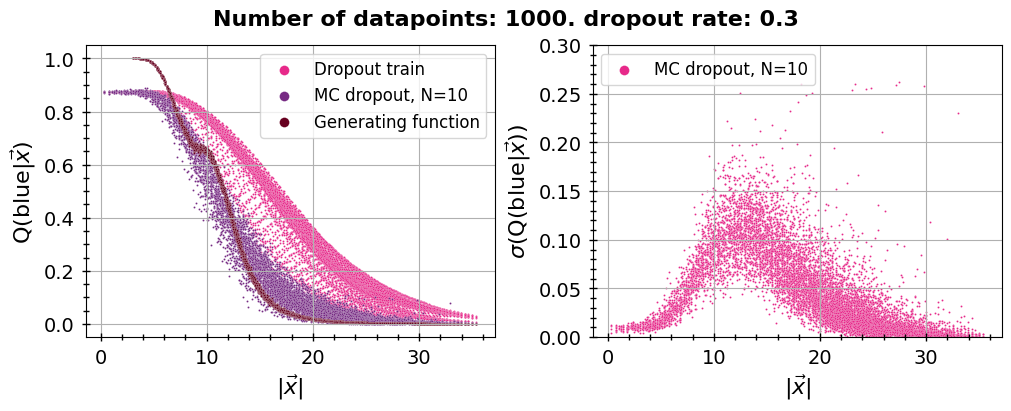

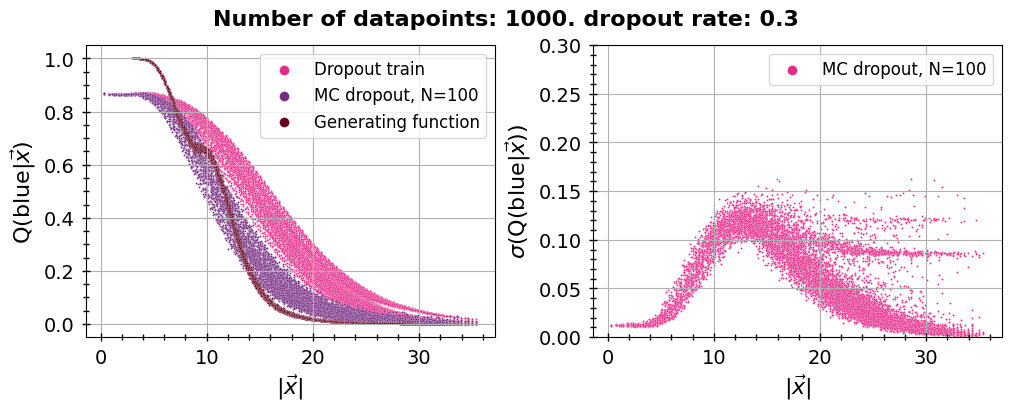

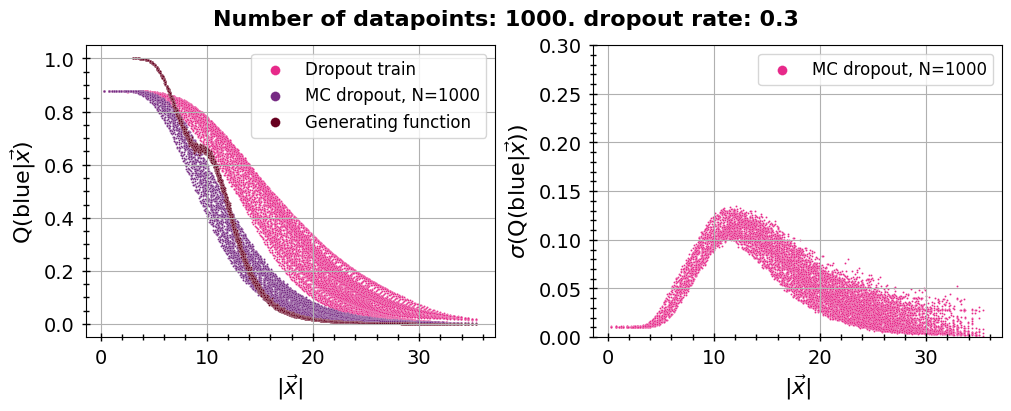

In [41]:

for i in range(len(n_MC_list)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Confidence", s=2, ax = axs[0], label="Dropout train", color="#e7298a")
    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Confidence_MC", s=2, ax = axs[0], label=f"MC dropout, N={n_MC_list[i]}", color="#762a83")
    sn.scatterplot(truth_data, x="r_x", y="P_blue_given_x", s=2, ax = axs[0], label="Generating function", color="#67001f")
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_dfs_nMC[i], x="r_x", y=f"Std_MC", s=2, ax = axs[1], label=f"MC dropout, N={n_MC_list[i]}", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.3)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=12)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")

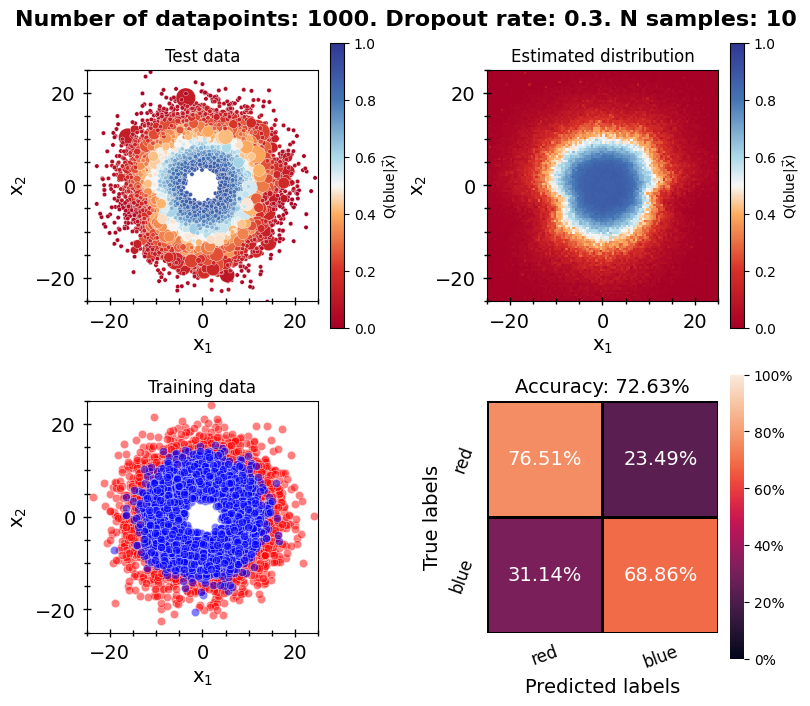

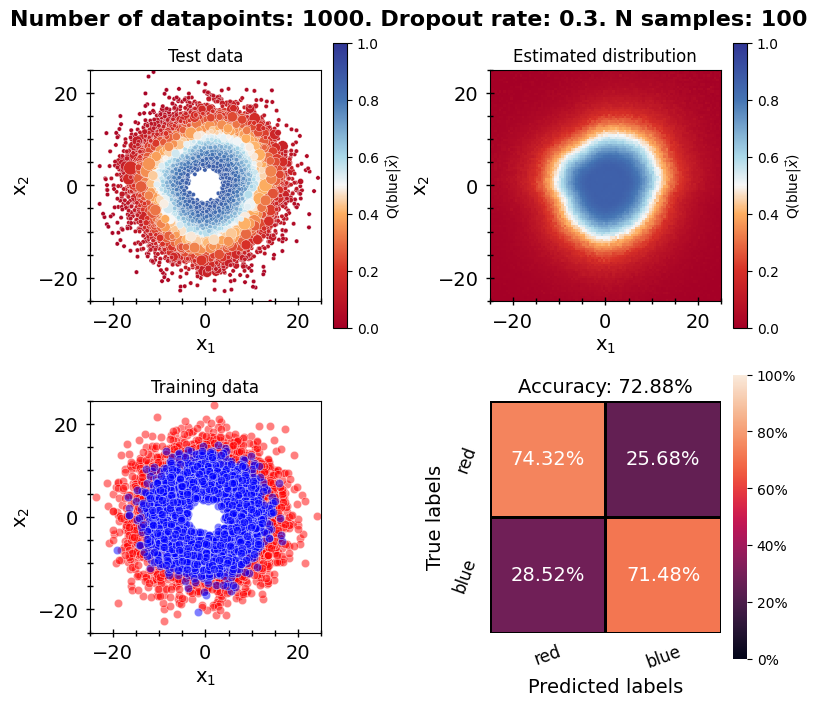

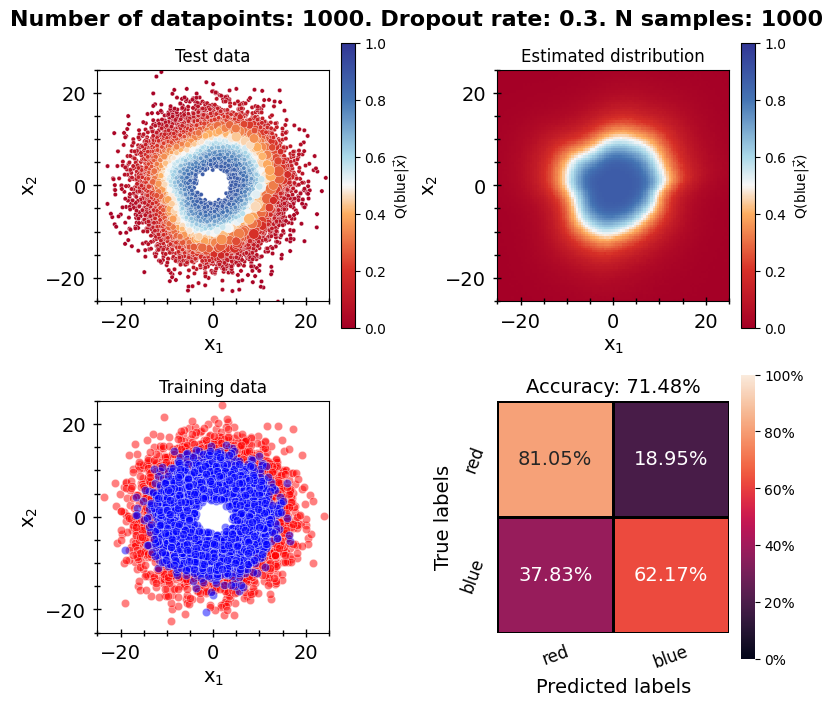

In [42]:
# Plot
for i in range(len(n_MC_list)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

    axs[0][0] = plot_results(test_dfs_nMC[i], f"Confidence_MC", axs[0][0], "Test data", error_key=f"Std_MC")
    axs[0][1] = plot_grid(grid_dfs_nMC[i], f"Confidence_MC", axs[0][1], "Estimated distribution")
    axs[1][1] = plot_conf_matrix(test_dfs_nMC[i], "class", f"Prediction_MC", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:5000], axs[1][0], "Training data")

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of datapoints: {n_train}. Dropout rate: {drop_out_rate}. N samples: {n_MC_list[i]}", size=16, fontweight="bold")


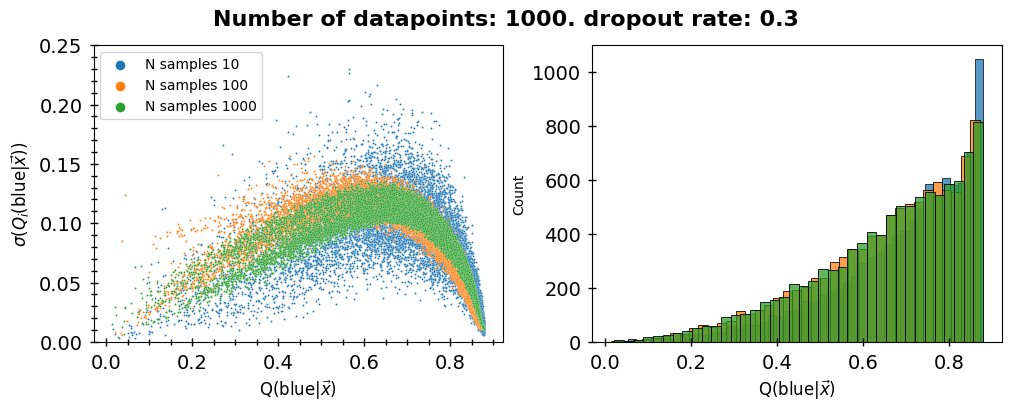

In [43]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_MC_list)):
    sn.scatterplot(test_dfs_nMC[i], x="Confidence", y=f"Std_MC", s=2, label=f"N samples {n_MC_list[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel(r"$\sigma$($Q_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)

    sn.histplot(test_dfs_nMC[i], x="Confidence", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")

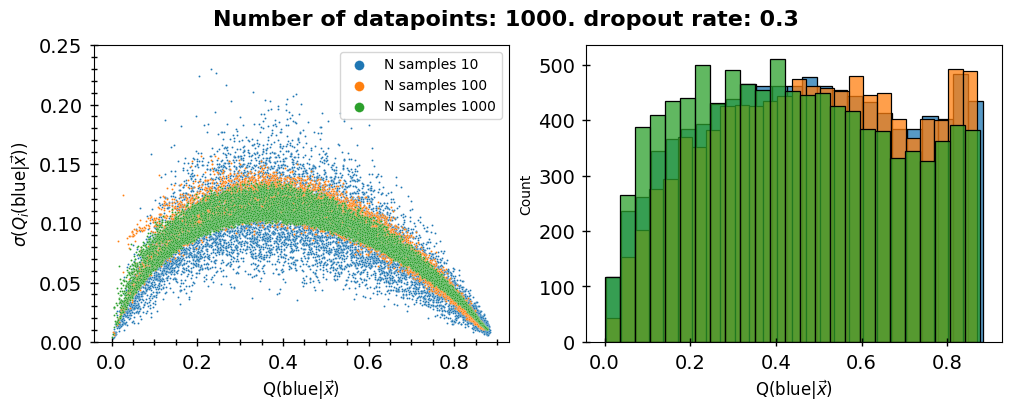

In [44]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_MC_list)):
    sn.scatterplot(test_dfs_nMC[i], x="Confidence_MC", y=f"Std_MC", s=2, label=f"N samples {n_MC_list[i]}", ax = axs[0])
    axs[0].legend(markerscale=5)
    axs[0].set_ylabel(r"$\sigma$($Q_i$(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)

    sn.histplot(test_dfs_nMC[i], x="Confidence_MC", ax = axs[1])
    axs[1].set_ylabel("Count")
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)

    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    fig.suptitle(f"Number of datapoints: {n_train}. dropout rate: {drop_out_rate}", size=16, fontweight="bold")